### Chris Hamm 2019-09-23 (initial code)
A jupyter notebook to add *Neonympha* images from **MUSEUM IMAGEs**. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [2]:
from fastai import *
from fastai.vision import *

In [3]:
np.random.seed(1138)

Now prepare to download the files to our repo

In [4]:
mimage_path = "../data/images/Museum"

Nar

In [ ]:
# Nar_folder = "Nar"
# Nar_file = "Nar_photos.txt"
# Nar_path = Path('../data/images/Museum/Nar')
# Nar_dest = Nar_path/Nar_folder
# Nar_dest.mkdir(parents = True, exist_ok = True)

Nmi

In [ ]:
# Nmi_folder = "Nmi"
# Nmi_file = "Nmi_photos.txt"
# Nmi_path = Path('../data/images/Museum/Nmi')
# Nmi_dest = Nmi_path/Nmi_folder
# Nmi_dest.mkdir(parents = True, exist_ok = True)

Nfr

In [ ]:
# Nfr_folder = "Nfr"
# Nfr_file = "Nfr_photos.txt"
# Nfr_path = Path('../data/images/Museum/Nfr')
# Nfr_dest = Nfr_path/Nfr_folder
# Nfr_dest.mkdir(parents = True, exist_ok = True)

Nhe

In [ ]:
# Nhe_folder = "Nhe"
# Nhe_file = "Nhe_photos.txt"
# Nhe_path = Path('../data/images/Museum/Nhe')
# Nhe_dest = Nhe_path/Nhe_folder
# Nhe_dest.mkdir(parents = True, exist_ok = True)

Download the images

In [5]:
classes = ['Nar', 'Nmi', 'Nfr', 'Nhe']

In [ ]:
#download_images(Nar_path/Nar_file, Nar_dest, max_pics = 50)
#download_images(Nmi_path/Nmi_file, Nmi_dest, max_pics = 50)
#download_images(Nfr_path/Nfr_file, Nfr_dest, max_pics = 50)
#download_images(Nhe_path/Nhe_file, Nhe_dest, max_pics = 50)

Commenting the original code while I mess with the progressive resizing

In [6]:
transforms = get_transforms(flip_vert = True, max_warp = 0.1, \
                            max_zoom = 1.05, )

In [8]:
data_64 = ImageDataBunch.from_folder(path = mimage_path, train = ".", 
                                         valid_pct = 0.2, ds_tfms = transforms,
                                        size = 64, num_workers = 4, bs = 64).normalize(imagenet_stats)

In [9]:
data_64

ImageDataBunch;

Train: LabelList (1165 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Nar,Nar,Nar,Nar,Nar
Path: ../data/images/Museum;

Valid: LabelList (291 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Nmi,Nhe,Nmi,Nar,Nmi
Path: ../data/images/Museum;

Test: None

In [10]:
print(data_64.classes)

['Nar', 'Nfr', 'Nhe', 'Nmi']


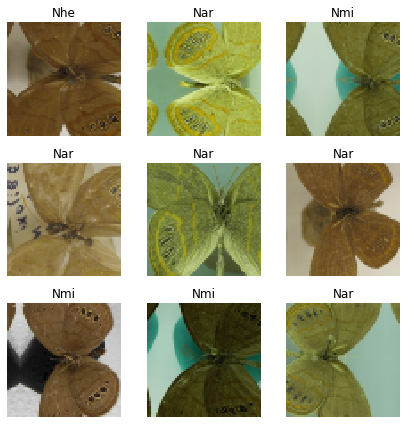

In [11]:
data_64.show_batch(rows = 3, figsize = (6, 6))

### `resnet34`

In [12]:
# with 64 sized images
learn_rn34 = cnn_learner(data_64, \
                            models.resnet34, \
                            metrics = error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:08<00:00, 10.6MB/s]


In [13]:
learn_rn34.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


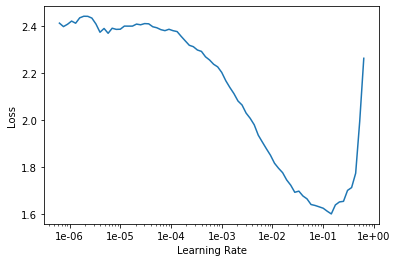

In [14]:
learn_rn34.recorder.plot()

In [15]:
learn_rn34.fit_one_cycle(5, max_lr = slice(1e-03, 1e-02)) 
# with specified LR, get error rate of 12-15% after 5 cycles

epoch,train_loss,valid_loss,error_rate,time
0,1.498199,0.813569,0.223368,00:40
1,1.100944,0.472123,0.175258,00:39
2,0.865153,0.357010,0.161512,00:39
3,0.717329,0.291555,0.144330,00:40
4,0.624885,0.265160,0.123711,00:40


In [16]:
learn_rn34.save('aug_stage_1_64_rn34')

In [ ]:
#learn_rn34.load('aug_stage_1_64_rn34')

### Now the progressive augmentation

In [18]:
data_128 = ImageDataBunch.from_folder(path = mimage_path, \
                                      train = ".", \
                                      valid_pct = 0.2, \
                                      ds_tfms = transforms, \
                                      size = 128, num_workers = 4, \
                                      bs = 64).normalize(imagenet_stats)

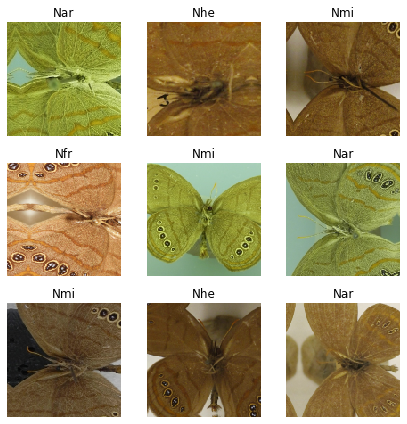

In [19]:
data_128.show_batch(rows = 3, figsize = (6, 6))

In [20]:
learn_rn34.unfreeze()
learn_rn34.data = data_128
learn_rn34.freeze()

In [21]:
learn_rn34.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


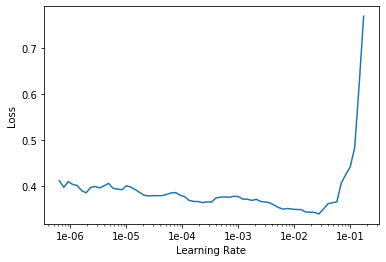

In [22]:
learn_rn34.recorder.plot()

In [23]:
learn_rn34.fit_one_cycle(3, max_lr = slice(1e-03, 1e-02)) # 8% after 2 epochs

epoch,train_loss,valid_loss,error_rate,time
0,0.433723,0.331881,0.106529,00:42
1,0.408837,0.171133,0.079038,00:42
2,0.338184,0.216480,0.092784,00:42


In [24]:
learn_rn34.save('aug_stage_2_128_rn34') 

#### 256 images

In [26]:
data_256 = ImageDataBunch.from_folder(path = mimage_path, \
                                      train = ".", \
                                      valid_pct = 0.2, \
                                      ds_tfms = transforms, \
                                      size = 256, num_workers = 4, \
                                      bs = 32).normalize(imagenet_stats)

In [27]:
learn_rn34.unfreeze()
learn_rn34.data = data_256
learn_rn34.freeze()

In [28]:
learn_rn34.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


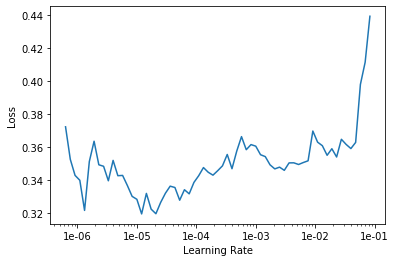

In [29]:
learn_rn34.recorder.plot()

In [30]:
learn_rn34.fit_one_cycle(4, max_lr = slice(1e-03, 1e-02)) # 6% error

epoch,train_loss,valid_loss,error_rate,time
0,0.328597,0.203639,0.075601,00:43
1,0.360054,0.170622,0.065292,00:43
2,0.297225,0.198914,0.068729,00:42
3,0.238698,0.196201,0.068729,00:44


In [31]:
learn_rn34.save('aug_stage_3_256_rn34')

#### Examine problem areas

In [ ]:
# It is OK for train loss to be lower than valid loss. That is what you want.
# As long as you are training and error is improving you are not overfitting.

In [32]:
interpretation_34 = ClassificationInterpretation.from_learner(learn_rn34)

losses_34, idxs_34 = interpretation_34.top_losses()

len(data_256.valid_ds) == len(losses_34) == len(idxs_34)

True

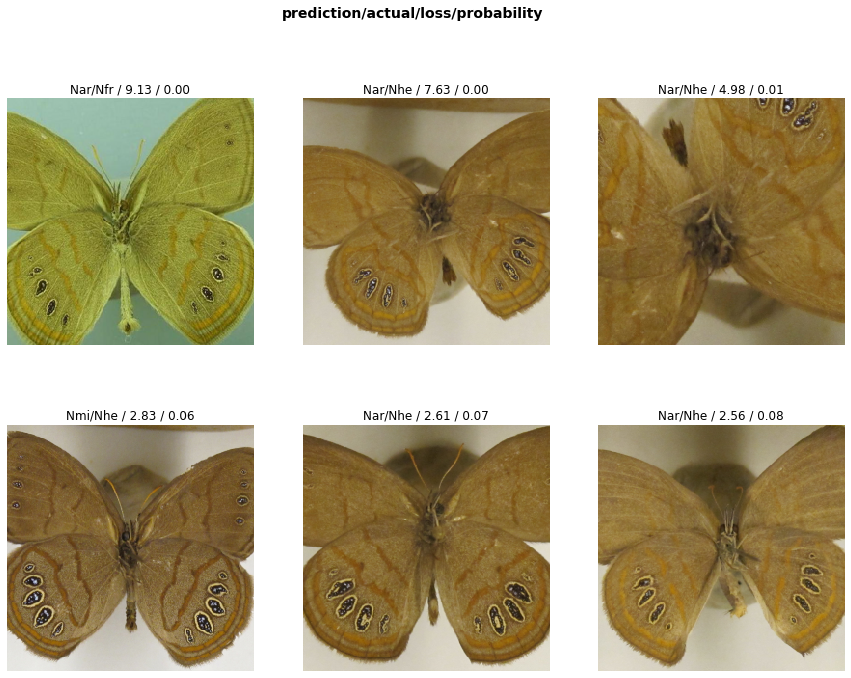

In [33]:
interpretation_34.plot_top_losses(6, figsize = (15, 11))

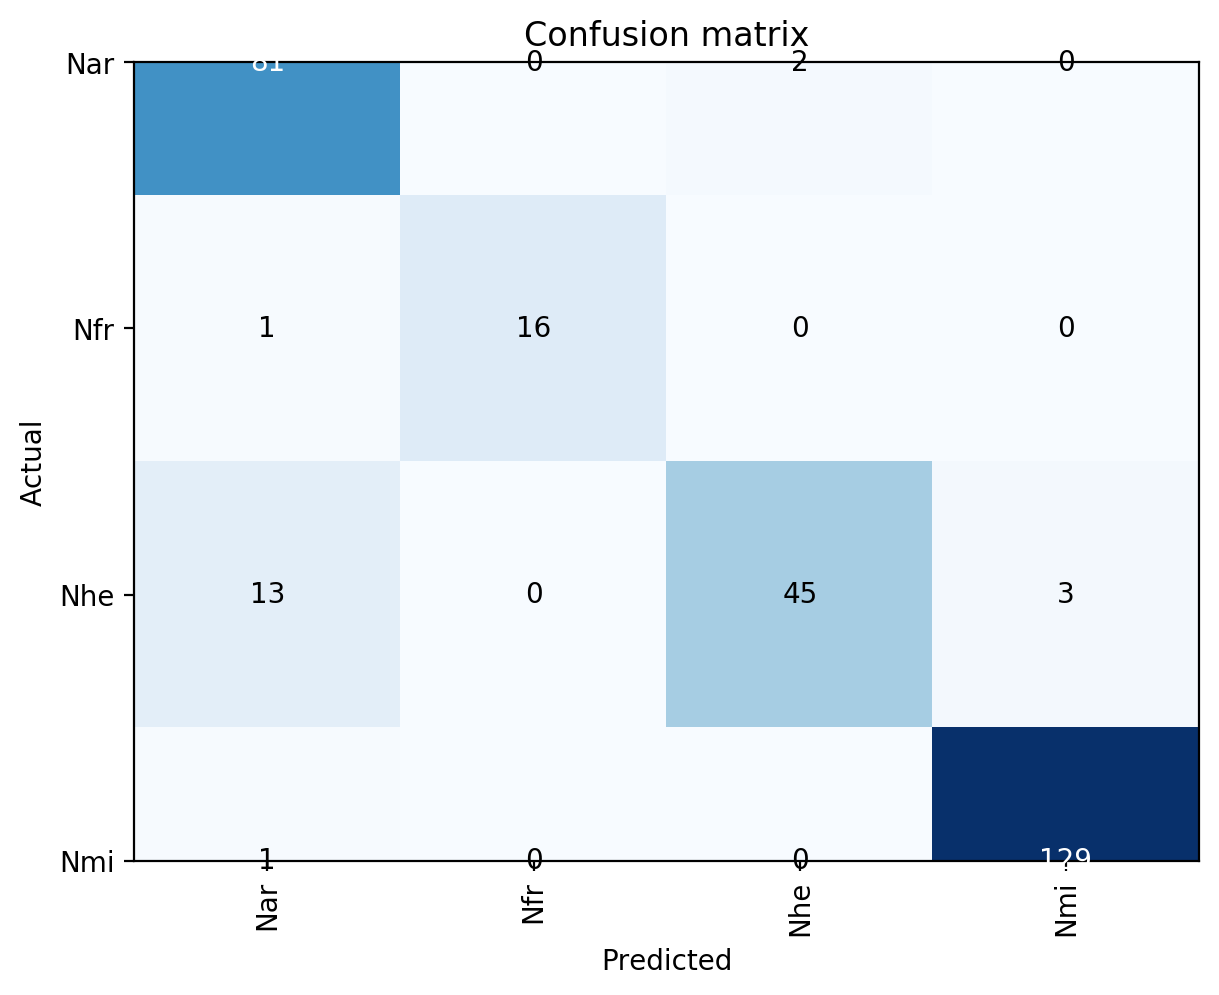

In [34]:
interpretation_34.plot_confusion_matrix(figsize = (6, 6), dpi = 200)

In [35]:
interpretation_34.most_confused(min_val = 0) 

[('Nhe', 'Nar', 13),
 ('Nhe', 'Nmi', 3),
 ('Nar', 'Nhe', 2),
 ('Nfr', 'Nar', 1),
 ('Nmi', 'Nar', 1),
 ('Nar', 'Nar', 0),
 ('Nar', 'Nfr', 0),
 ('Nar', 'Nmi', 0),
 ('Nfr', 'Nfr', 0),
 ('Nfr', 'Nhe', 0),
 ('Nfr', 'Nmi', 0),
 ('Nhe', 'Nfr', 0),
 ('Nhe', 'Nhe', 0),
 ('Nmi', 'Nfr', 0),
 ('Nmi', 'Nhe', 0),
 ('Nmi', 'Nmi', 0)]

### `resnet50`

Re run the code to generate the `data_64` object. 

In [37]:
# with 64 sized images
learn_rn50 = cnn_learner(data_64, \
                            models.resnet50, \
                            metrics = error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:09<00:00, 10.4MB/s]


Get the learning rate

In [38]:
learn_rn50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


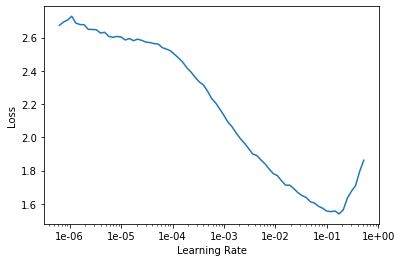

In [39]:
learn_rn50.recorder.plot()

Use the best (steepest) LR for the model

In [40]:
learn_rn50.fit_one_cycle(4, max_lr = slice(1e-03, 1e-02)) 
# with specified LR, get error rate of ~14% after 4 cycles

epoch,train_loss,valid_loss,error_rate,time
0,1.465208,1.601668,0.230241,00:41
1,0.999923,0.462224,0.130584,00:42
2,0.784384,0.380861,0.137457,00:43
3,0.640721,0.335532,0.137457,00:42


Save the model, fine tune, and save

In [41]:
learn_rn50.save('stage_1_64_rn50')

In [ ]:
#learn_rn50.load('stage_1_64_rn50')

Now the progressive augmentation

In [43]:
learn_rn50.unfreeze()
learn_rn50.data = data_128
learn_rn50.freeze()

Find the optimal learning rate

In [44]:
learn_rn50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


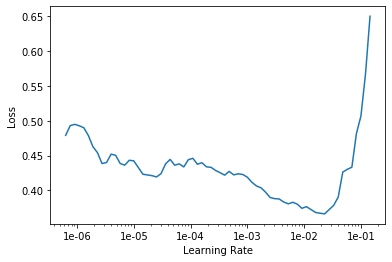

In [45]:
learn_rn50.recorder.plot()

In [46]:
learn_rn50.fit_one_cycle(2, max_lr = slice(1e-03, 1e-02)) # 9% error

epoch,train_loss,valid_loss,error_rate,time
0,0.438598,0.444930,0.113402,00:43
1,0.354744,0.225928,0.092784,00:42


In [47]:
learn_rn50.save('stage_2_128_rn50')

In [48]:
learn_rn50.unfreeze()
learn_rn50.data = data_256
learn_rn50.freeze()

In [49]:
learn_rn50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


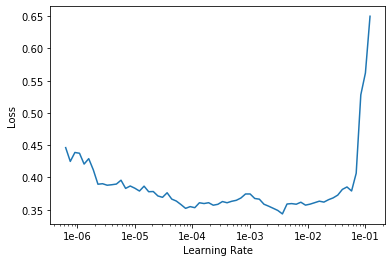

In [50]:
learn_rn50.recorder.plot()

In [51]:
learn_rn50.fit_one_cycle(4) # 6% error

epoch,train_loss,valid_loss,error_rate,time
0,0.312572,0.218756,0.089347,00:46
1,0.239998,0.215436,0.068729,00:45
2,0.222367,0.179248,0.068729,00:45
3,0.190208,0.178740,0.079038,00:46


In [52]:
learn_rn50.save('stage_3_256_rn50')

### Problem areas

In [53]:
interpretation_50 = ClassificationInterpretation.from_learner(learn_rn50)

losses_50, idxs_50 = interpretation_50.top_losses()

len(data_128.valid_ds) == len(losses_50) == len(idxs_50)

True

In [ ]:
# learn_rn50.load('stage_3_128_rn50')

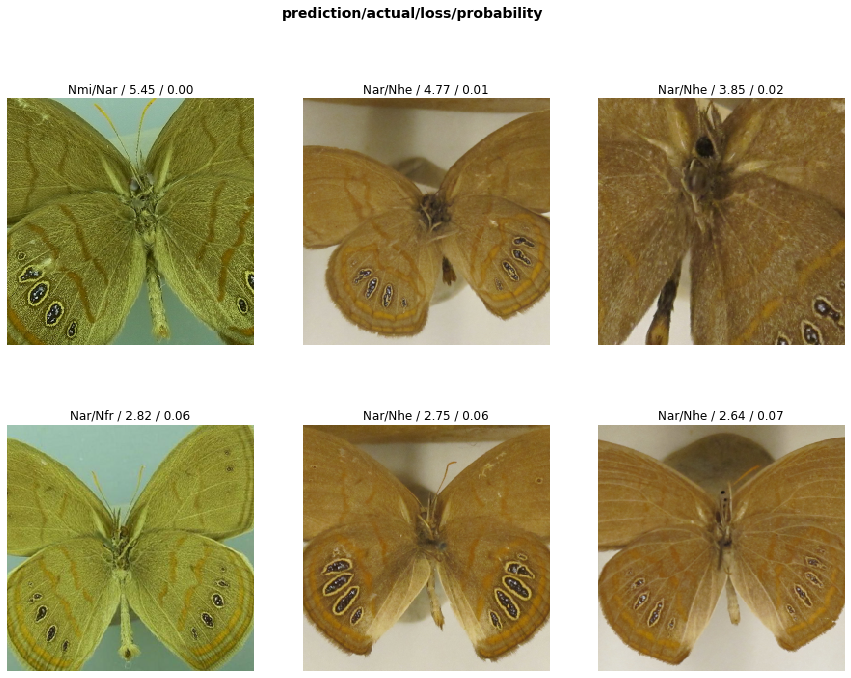

In [54]:
interpretation_50.plot_top_losses(6, figsize = (15, 11))

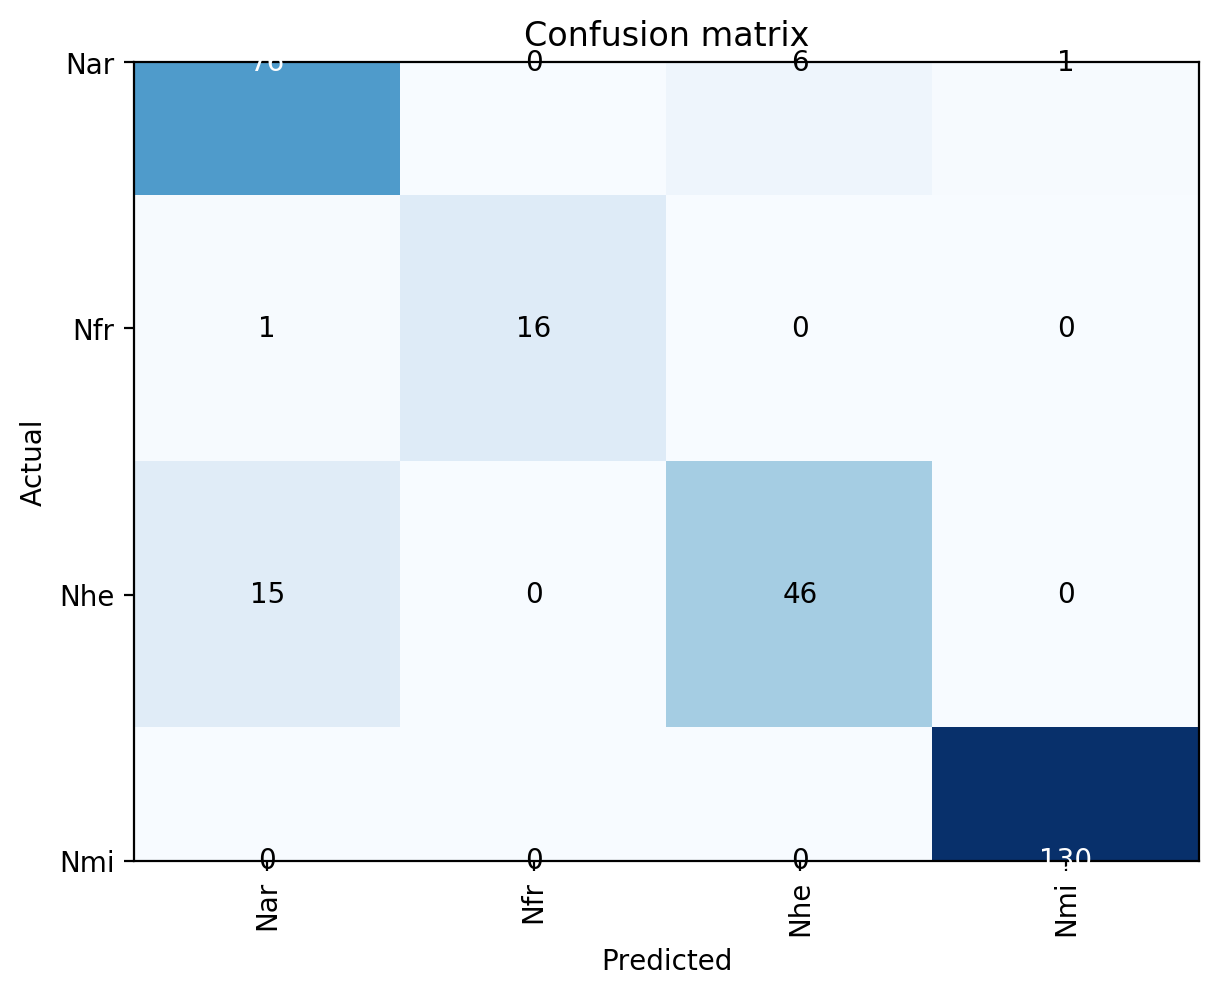

In [55]:
interpretation_50.plot_confusion_matrix(figsize = (6, 6), dpi = 200)

In [56]:
interpretation_50.most_confused(min_val = 0) # same problems as resnet34.

[('Nhe', 'Nar', 15),
 ('Nar', 'Nhe', 6),
 ('Nar', 'Nmi', 1),
 ('Nfr', 'Nar', 1),
 ('Nar', 'Nar', 0),
 ('Nar', 'Nfr', 0),
 ('Nfr', 'Nfr', 0),
 ('Nfr', 'Nhe', 0),
 ('Nfr', 'Nmi', 0),
 ('Nhe', 'Nfr', 0),
 ('Nhe', 'Nhe', 0),
 ('Nhe', 'Nmi', 0),
 ('Nmi', 'Nar', 0),
 ('Nmi', 'Nfr', 0),
 ('Nmi', 'Nhe', 0),
 ('Nmi', 'Nmi', 0)]